# Creando el Basic Block

In [1]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity=self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out=nn.ReLU()(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out+=identity
        out=nn.ReLU()(out)
        return out

# Construcción de la Red Resnet 18

In [2]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks,stride):
        layers=[]
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.avg_pool(x)
        x=torch.flatten(x, 1)
        x=self.fc(x)
        return x

# Carga de datos cifar-10

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [4]:
import torchvision.transforms as transforms
import  torchvision
transform_train=transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
])

batch_size=128
trainset=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader=torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
#definir de cifar-10
classes = ('avión', 'automóvil', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión')


100.0%


# Cargar el modelo Resnett 18

In [5]:
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Entrenamiento del modelo

In [6]:
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct=0
    total=0

    for images, labels in trainloader:
        images, labels=images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted== labels).sum().item()
    scheduler.step()
    epoch_loss = running_loss/len(trainloader)
    epoch_acc=100*correct/total
    print(f"Época [{epoch+1}/{num_epochs}, Pérdida: {epoch_loss:.4f}, Precisión: {epoch_acc:.2f}]")



Época [1/20, Pérdida: 1.4845, Precisión: 45.25]
Época [2/20, Pérdida: 0.9990, Precisión: 64.26]
Época [3/20, Pérdida: 0.7970, Precisión: 71.98]
Época [4/20, Pérdida: 0.6637, Precisión: 77.11]
Época [5/20, Pérdida: 0.5662, Precisión: 80.24]
Época [6/20, Pérdida: 0.4966, Precisión: 82.75]
Época [7/20, Pérdida: 0.4426, Precisión: 84.64]
Época [8/20, Pérdida: 0.4046, Precisión: 86.06]
Época [9/20, Pérdida: 0.3701, Precisión: 87.05]
Época [10/20, Pérdida: 0.3370, Precisión: 88.38]
Época [11/20, Pérdida: 0.2290, Precisión: 92.13]
Época [12/20, Pérdida: 0.1985, Precisión: 93.14]
Época [13/20, Pérdida: 0.1889, Precisión: 93.54]
Época [14/20, Pérdida: 0.1736, Precisión: 94.10]
Época [15/20, Pérdida: 0.1657, Precisión: 94.26]
Época [16/20, Pérdida: 0.1577, Precisión: 94.49]
Época [17/20, Pérdida: 0.1500, Precisión: 94.75]
Época [18/20, Pérdida: 0.1436, Precisión: 95.07]
Época [19/20, Pérdida: 0.1339, Precisión: 95.35]
Época [20/20, Pérdida: 0.1280, Precisión: 95.50]


#Evaluación del modelo en datos de prueba

In [7]:
model.eval()
correct=0
total=0
with torch.no_grad():
    for images, labels in testloader:
        images, labels=images.to(device), labels.to(device)
        outputs=model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=predicted.eq(labels).sum().item()
accuracy=100*correct/total
print(f"Precisión en el conjunto de pruebas: {accuracy:.2f}%")

Precisión en el conjunto de pruebas: 90.87%


# Salvamos el modelo

In [8]:
save_path = "resnet18_cifar10.pth"
torch.save(model.state_dict(), save_path)
print(f"Modelo guardado en '{save_path}'")

✅ Modelo guardado en 'resnet18_cifar10.pth'


# Mostramos un test

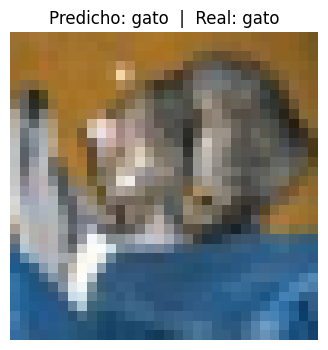

In [13]:
import matplotlib.pyplot as plt
import numpy as np

model = ResNet18(num_classes=10)
model.load_state_dict(torch.load("resnet18_cifar10.pth", map_location=device))
model = model.to(device)
model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)

img = images[0].unsqueeze(0).to(device) #[1,3,32,32]
true_label = labels[0].item()

with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    pred_label = predicted.item()


mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])
img_np = images[0].permute(1, 2, 0).cpu().numpy() #[3,32,32]
img_np = std * img_np + mean
img_np = np.clip(img_np, 0, 1)

plt.figure(figsize=(4, 4))
plt.imshow(img_np) #[32,32,3]
plt.title(f"Predicho: {classes[pred_label]}  |  Real: {classes[true_label]}")
plt.axis("off")
plt.show()